<h1 align="center" style="font-weight:bold">Week 4 - News Classification</h1>

<h3 align="center">By Ryan Ordonez</h3>

***

<h2 align="center" style="font-weight:bold">Project Overview</h2>

<p align="center">This project involves classifying over 2,000 BBC news articles into five distinct categories: Business, Entertainment, Politics, Sport, and Tech. <br>The dataset is split into two parts: 66% for training, where the category labels are already assigned, and 33% for testing, where the model must predict the correct category for unseen articles.<br>The objective is to build a model with high accuracy that can effectively classify new, unseen news articles based on their content.</p>

<p style="text-align: center;">
    <a href="https://www.kaggle.com/c/learn-ai-bbc/overview">Link to Kaggle Competition</a>
</p>

### **Table of Contents**

1. [Setup](#setup)
   - Installing Necessary Libraries
   - Import Packages
   - Import Kaggle Dataset
2. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
   - Inspect the Data
   - Initial Data Visualization
   - Clean the Data
   - Visualization After Cleaning
   - Feature Extraction
3. [Building and Training the Matrix Factorization Model](#building-and-training-the-matrix-factorization-model)
   - Matrix Factorization
   - Model Training and Prediction
   - Performance Evaluation
   - Hyperparameter Tuning
   - Improving Model Performance
4. [Comparison with Supervised Learning](#comparison-with-supervised-learning)
   - Supervised Model Setup
   - Performance Comparison
5. [Summary/Conclusion](#summary-conclusion)
6. [Deliverables](#deliverables)
7. [Reference List](#reference-list)

***

<h2 id="setup" align="center" style="font-weight:bold">Setup</h2>

### Installing Necessary Libraries

First, we will install the necessary libraries for our project. The installation process will run quietly, and if any library is already installed, the user won’t see unnecessary warnings.

In [62]:
# Data manipulation and numerical processing
import os
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning tools
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Text processing tools
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

# Other tools
import warnings
warnings.filterwarnings('ignore')  # Ignore warnings for cleaner output

# Download NLTK data quietly
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)

True

### Load the Datasets

I saved them to my github account so you can import directly in case they are not saved on your local machine or you don't have a kaggle account api.

In [63]:
# Load the data 
# 'train' dataset: Contains labeled BBC news articles used for training the model.
# 'test' dataset: Contains unlabeled BBC news articles where the model will predict the category.
# 'sample_solution' dataset: Provides the template for submission to kaggle to check test accuracy. 

train_path = 'https://raw.githubusercontent.com/RyanOrdonez/DTSA5510_Week4_NewsClassification/refs/heads/main/BBC%20News%20Train.csv'
train = pd.read_csv(train_path)

test_path = 'https://raw.githubusercontent.com/RyanOrdonez/DTSA5510_Week4_NewsClassification/refs/heads/main/BBC%20News%20Test.csv'
test = pd.read_csv(test_path)

sample_solution_path = 'https://raw.githubusercontent.com/RyanOrdonez/DTSA5510_Week4_NewsClassification/refs/heads/main/BBC%20News%20Sample%20Solution.csv'
sample_solution = pd.read_csv(sample_solution_path)

***

<h2 id="exploratory-data-analysis-eda" align="center" style="font-weight:bold">Exploratory Data Analysis (EDA)</h2>

<p id="exploratory-data-analysis-eda" align="center">In this step, we'll explore the training dataset to understand its structure, visualize key patterns, and clean it for further analysis. 
<br> By the end of this step, we will have a clearer picture of how the data is organized and how to proceed with text processing and model building.</p>

### <u>Inspect the Data</u>
We start by inspecting the data to understand its overall structure, identify the data types, and check for missing values.

This helps us know what we're working with and spot any potential issues.

In [64]:
# Inspect the first few rows of the training dataset
train.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [65]:
# Inspect the first few rows of the test dataset
test.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [66]:
# Get more information about the dataset structure (column types, non-null values)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.1+ KB


In [67]:
# Check for missing values in each column
train.isnull().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

The dataset consists of 1,490 entries and includes three columns: ArticleId, Text, and Category. The ArticleId column contains unique identifiers for each article, while the Text column holds the content of the articles. The Category column labels each article with a specific category, such as "business" or "tech." All columns are complete, with no missing values, and the data types are appropriate for each field. This provides a clean foundation for further analysis and processing.

***

### <u>Visualize the Data</u>
I will create charts to visualize the distribution of categories and the most frequent words throughout the dataset. This will help me understand the overall structure of the dataset and identify any potential steps I need to take for further cleaning, such as removing irrelevant or overly common words. Additionally, these charts will provide insight into whether the categories are balanced and whether there are any irregularities in the distribution that might require attention before proceeding with model training.

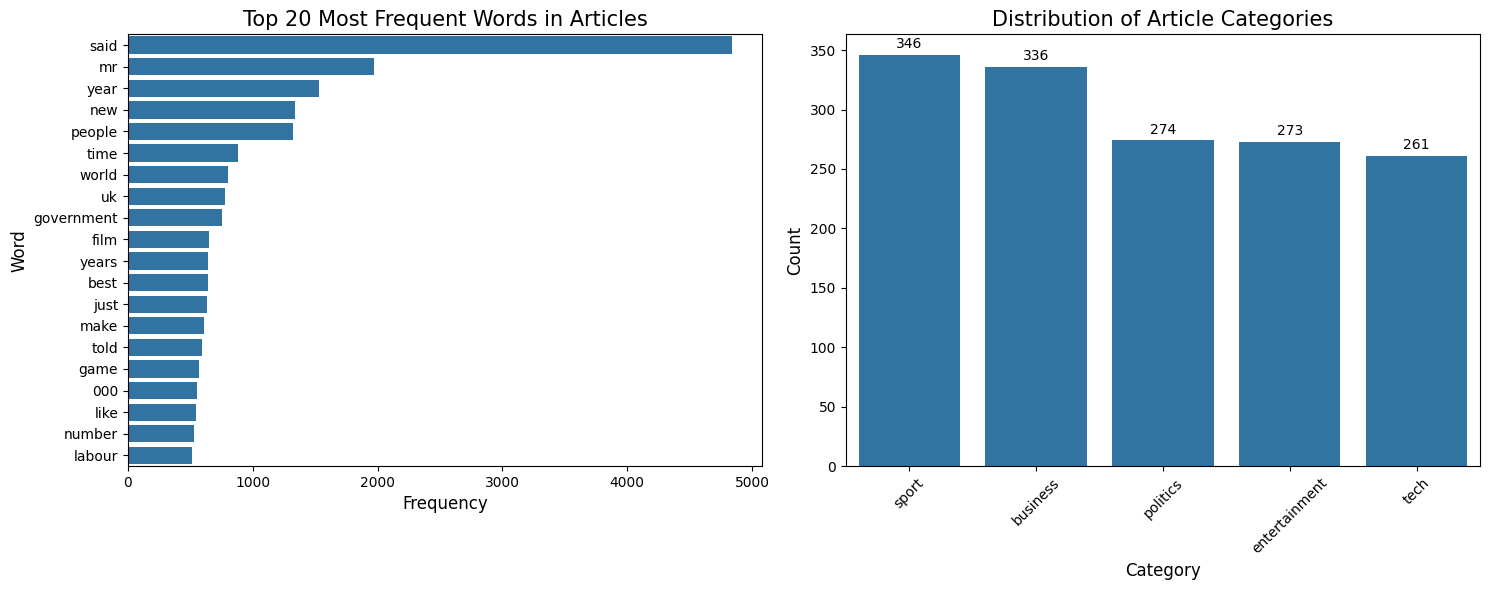

In [68]:
# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Word Frequency Plot (Top 20 words)
vectorizer = CountVectorizer(stop_words='english', max_features=20)  # Top 20 words
X_counts = vectorizer.fit_transform(train['Text'])
word_counts = X_counts.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# Prepare DataFrame
word_freq_df = pd.DataFrame({'word': words, 'count': word_counts})
word_freq_df = word_freq_df.sort_values(by='count', ascending=False)

# Plot on the first subplot (ax1)
sns.barplot(x='count', y='word', data=word_freq_df, ax=ax1)
ax1.set_title('Top 20 Most Frequent Words in Articles', fontsize=15)
ax1.set_xlabel('Frequency', fontsize=12)
ax1.set_ylabel('Word', fontsize=12)

# 2. Category Distribution Plot
category_order = train['Category'].value_counts().index

# Plot on the second subplot (ax2)
sns.countplot(x='Category', data=train, order=category_order, ax=ax2)
ax2.set_title('Distribution of Article Categories', fontsize=15)
ax2.set_xlabel('Category', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)

# Add counts on top of each bar
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='baseline', fontsize=10, color='black', 
                 xytext=(0, 5), textcoords='offset points')

# Adjust layout
plt.tight_layout()
plt.show()

After reviewing the word frequency chart, I noticed the presence of several common words that may not contribute much to distinguishing between categories. To improve the dataset, I will work on removing or refining stop words and consider adding more sophisticated text preprocessing techniques. The category distribution chart shows a relatively balanced spread across categories, without any extra categories or obvious irregularities. However, I will double-check for potential duplicate articles or slightly modified articles that could skew the category distribution, ensuring that the dataset accurately reflects the intended classification task.

***

### <u>Clean the Data</u>

#### Check for Duplicates

Before we proceed, it’s important to ensure there are no duplicate entries in the dataset. Duplicates can introduce bias into the model, as repeated articles could be counted multiple times, leading to inaccurate results. First, we will check for exact duplicates in both the ArticleId and Text columns to identify and remove any redundant entries.

In [69]:
# Check for duplicate ArticleIDs
duplicate_article_ids = train[train.duplicated(subset='ArticleId')]
print(f"Number of duplicate ArticleIDs: {duplicate_article_ids.shape[0]}")

# Check for duplicate Text entries
duplicate_texts = train[train.duplicated(subset='Text')]
print(f"Number of duplicate Text entries: {duplicate_texts.shape[0]}")

Number of duplicate ArticleIDs: 0
Number of duplicate Text entries: 50


Seeing that there are no duplicate AricleIDs, we will only need to remove the duplicate Text entries.

In [70]:
# Remove all exact duplicate Text entries (keep only unique texts)
train_cleaned = train.drop_duplicates(subset='Text', keep='first')

# Display the number of remaining entries after removing duplicates
print(f"Number of entries after removing exact duplicates: {train_cleaned.shape[0]}")

Number of entries after removing exact duplicates: 1440


In addition to exact duplicates, there might be articles that are not identical but very similar — for example, slightly edited versions of the same news article. These can also impact the model’s accuracy if left in the dataset. To detect these, we will compute the similarity between articles using cosine similarity on the TF-IDF vectorized text. Articles with a similarity score of 90% or more will be considered near-duplicates and reviewed for removal.

In [71]:
# Convert the Text column into TF-IDF features
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(train_cleaned['Text'])

# Calculate the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Set a threshold for similarity (e.g., 0.90 or 90%)
similarity_threshold = 0.90

# Find pairs of articles with similarity above the threshold
similar_pairs = np.argwhere(cosine_sim_matrix > similarity_threshold)

# Filter out self-matches (article compared with itself)
similar_pairs = similar_pairs[similar_pairs[:, 0] != similar_pairs[:, 1]]

# Print the number of highly similar articles found
print(f"Number of highly similar articles: {len(similar_pairs)}")

Number of highly similar articles: 64


We found 64 articles that are highly similar (90% or greater similarity). We will try to remove these keeping only one unique version of the text. 

In [72]:
# Create a set of articles that are highly similar to any other article
similar_article_indices = set(similar_pairs[:, 1])

# Now go through each article in this list and decide if it should be dropped
articles_to_remove = set()

for index in similar_article_indices:
    # Convert relative position to actual DataFrame index
    actual_index = train_cleaned.index[index]
    
    # Check if this article is similar to any others in the cleaned dataset
    similar_to_others = False
    for other_index in similar_article_indices:
        if index != other_index:
            other_actual_index = train_cleaned.index[other_index]
            if cosine_sim_matrix[index, other_index] > similarity_threshold:
                similar_to_others = True
                break
    
    # If it's similar to any others, mark it for removal
    if similar_to_others:
        articles_to_remove.add(actual_index)

# Remove all articles marked for removal
train_cleaned_final = train_cleaned.drop(articles_to_remove, axis=0)

# Display the number of remaining articles
print(f"Number of entries after removing similar articles: {train_cleaned_final.shape[0]}")

Number of entries after removing similar articles: 1376


#### Clean Text Entries

Now that we've removed duplicate and highly similar articles, the next step is to clean the text data. This is an important preprocessing step, as it ensures consistency in the text and removes any noise that might negatively impact the model's performance. We’ll convert the text to lowercase, remove punctuation, and filter out stop words (common words like "the" and "is" that don’t provide much value in classification tasks).

In [73]:
# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# You can also add custom stop words if needed
custom_stop_words = {'said', 'mr', 'mrs'}  # Add "said" and other frequent words here
stop_words.update(custom_stop_words)

# Function to clean the text data (with lemmatization)
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)  # Remove all punctuation
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)  # Remove all digits
    
    # Tokenize the text into words
    words = word_tokenize(text)
    
    # Remove stop words and apply lemmatization
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    
    # Rejoin the words into a single string and remove extra spaces
    cleaned_text = ' '.join(words)
    cleaned_text = re.sub(' +', ' ', cleaned_text)  # Remove any extra spaces
    
    return cleaned_text

# Apply the improved cleaning function to the 'Text' column in training data
train_cleaned_final['cleaned_text'] = train_cleaned_final['Text'].apply(clean_text)

# Apply the same cleaning function to the test data
test['cleaned_text'] = test['Text'].apply(clean_text)

# Display the first few rows of the cleaned text
train_cleaned_final[['Text', 'cleaned_text']].head()


,Text,cleaned_text
0,worldcom ex-boss launches defence lawyers defe...,worldcom exboss launch defence lawyer defendin...
1,german business confidence slides german busin...,german business confidence slide german busine...
2,bbc poll indicates economic gloom citizens in ...,bbc poll indicates economic gloom citizen majo...
4,enron bosses in $168m payout eighteen former e...,enron boss payout eighteen former enron direct...
5,howard truanted to play snooker conservative...,howard truanted play snooker conservative lead...


#### <u>Visualize Data after Cleaning</u>

I always like to look at the data again to see how the cleaning changed the structure of the data. 

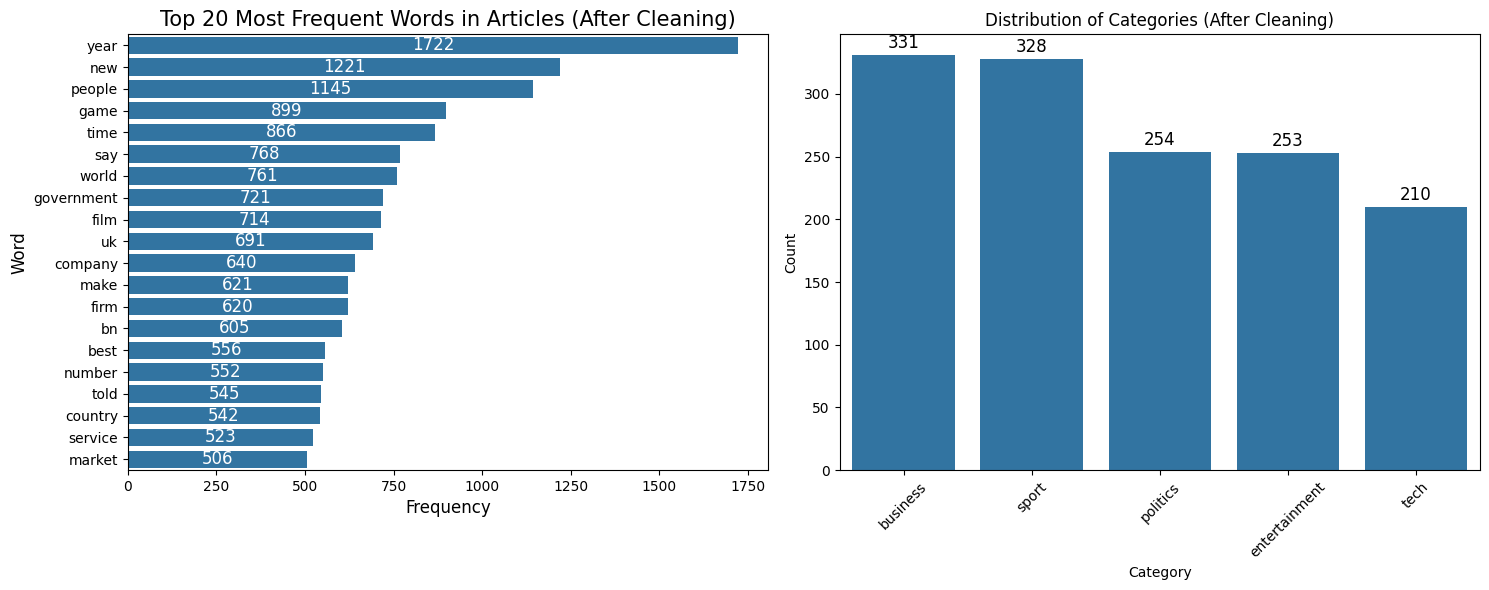

In [74]:
# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Word Frequency Plot (Top 20 words) - After Cleaning
vectorizer = CountVectorizer(stop_words='english', max_features=20)  # Top 20 words
X_counts = vectorizer.fit_transform(train_cleaned_final['cleaned_text'])
word_counts = X_counts.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# Prepare DataFrame
word_freq_df = pd.DataFrame({'word': words, 'count': word_counts})
word_freq_df = word_freq_df.sort_values(by='count', ascending=False)

# Plot on the first subplot (ax1)
sns.barplot(x='count', y='word', data=word_freq_df, ax=ax1)
ax1.set_title('Top 20 Most Frequent Words in Articles (After Cleaning)', fontsize=15)
ax1.set_xlabel('Frequency', fontsize=12)
ax1.set_ylabel('Word', fontsize=12)

# Add counts on top of each bar
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_width())}', (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() / 2.), 
                 ha='center', va='center', fontsize=12, color='white', xytext=(0, 0), 
                 textcoords='offset points')

# After cleaning
category_order_after = train_cleaned_final['Category'].value_counts().index
sns.countplot(x='Category', data=train_cleaned_final, order=category_order_after, ax=ax2)
ax2.set_title('Distribution of Categories (After Cleaning)')
ax2.set_xlabel('Category')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# Add counts on top of each bar
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='baseline', fontsize=12, color='black', xytext=(0, 5), 
                 textcoords='offset points')

# Show the side-by-side plot
plt.tight_layout()
plt.show()


I would like to also see what the word frequency looks like for each category. 

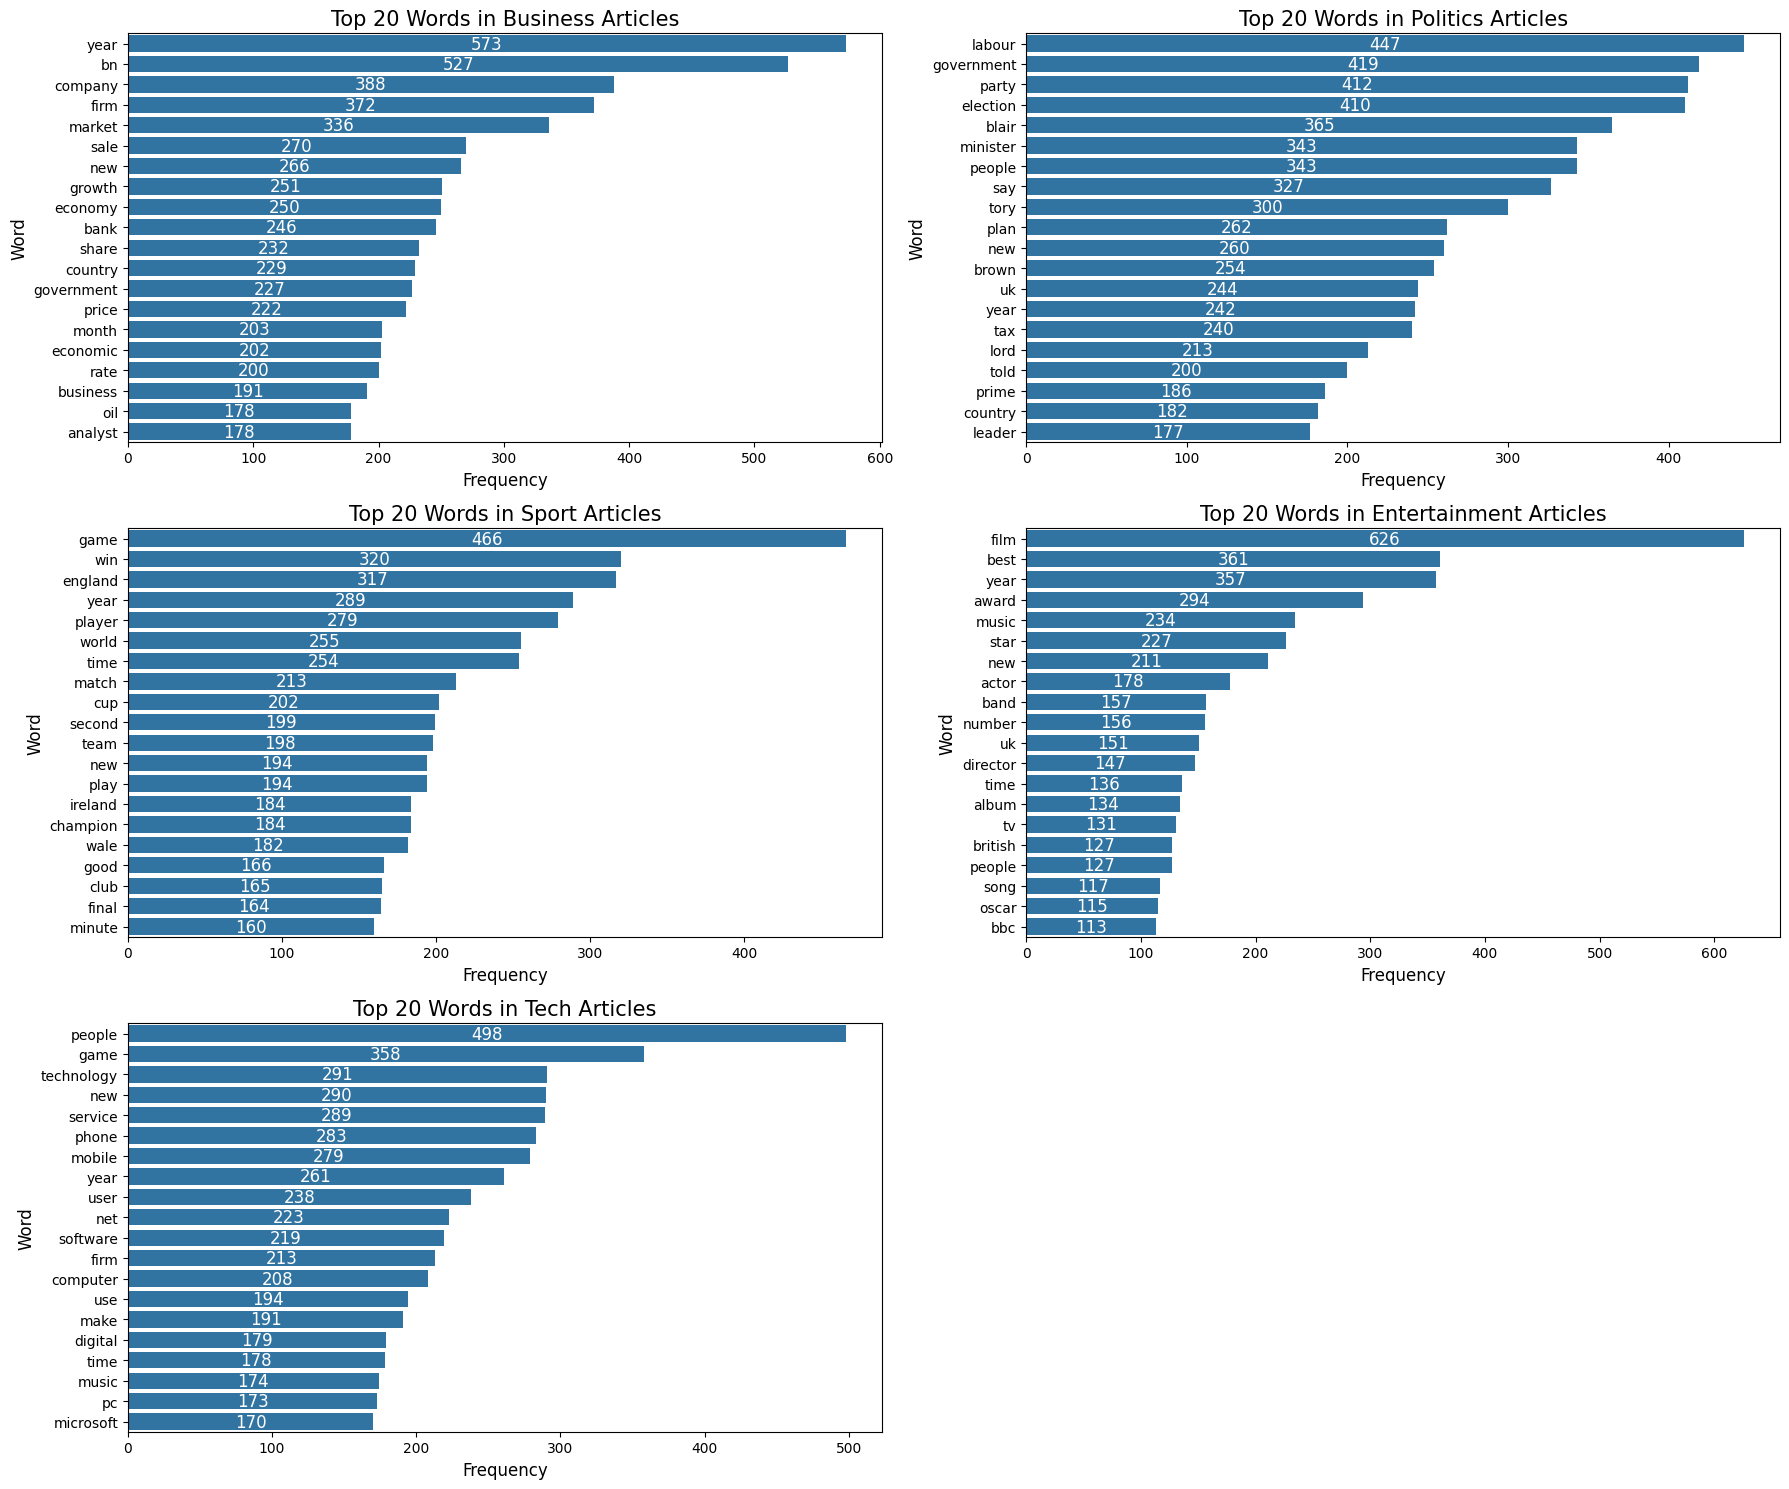

In [75]:
# Set up the figure for 5 subplots (one for each category)
fig, axes = plt.subplots(3, 2, figsize=(18, 15))  # 3x2 grid for better spacing, but only use 5 plots
fig.delaxes(axes[2, 1])  # Remove the unused subplot

# Define the categories
categories = train_cleaned_final['Category'].unique()

# Loop over each category and create a frequency plot for the top 20 words
for i, category in enumerate(categories):
    # Filter the dataframe for the current category
    category_data = train_cleaned_final[train_cleaned_final['Category'] == category]
    
    # Create the CountVectorizer for the current category
    vectorizer = CountVectorizer(stop_words='english', max_features=20)
    X_counts = vectorizer.fit_transform(category_data['cleaned_text'])
    
    # Calculate the word frequencies
    word_counts = X_counts.sum(axis=0).A1
    words = vectorizer.get_feature_names_out()
    
    # Prepare DataFrame for plotting
    word_freq_df = pd.DataFrame({'word': words, 'count': word_counts})
    word_freq_df = word_freq_df.sort_values(by='count', ascending=False)
    
    # Plot the word frequencies for the current category
    sns.barplot(x='count', y='word', data=word_freq_df, ax=axes[i // 2, i % 2])
    axes[i // 2, i % 2].set_title(f'Top 20 Words in {category.capitalize()} Articles', fontsize=15)
    axes[i // 2, i % 2].set_xlabel('Frequency', fontsize=12)
    axes[i // 2, i % 2].set_ylabel('Word', fontsize=12)
    
    # Add counts on top of each bar
    for p in axes[i // 2, i % 2].patches:
        axes[i // 2, i % 2].annotate(f'{int(p.get_width())}', 
                                     (p.get_x() + p.get_width() / 2., p.get_y() + p.get_height() / 2.), 
                                     ha='center', va='center', fontsize=12, color='white', 
                                     xytext=(0, 0), textcoords='offset points')

# Adjust the layout to ensure no overlapping
plt.tight_layout()
plt.show()


#### Summary of Category and Text Cleaning:

Category Cleaning: After processing the dataset, I identified and removed both exact duplicates and near-duplicate articles using cosine similarity with TF-IDF vectorization. This approach helped detect 50 exact duplicate articles and 64 articles with over 90% text similarity. By removing all but one article from each set of near-duplicates, the final dataset was reduced to 1,376 unique articles. This cleaning process slightly impacted the distribution across categories, with the tech category experiencing the largest reduction due to the removal of similar articles. Overall, the dataset retained a balanced category distribution while ensuring uniqueness.

Text Cleaning: The text cleaning involved several key steps to standardize and prepare the data for further analysis. First, the text was tokenized and converted to lowercase to maintain uniformity. Punctuation and stop words were removed to focus on the most relevant terms, and lemmatization was applied to reduce words to their base form. After cleaning, the top 20 most frequent words across the entire dataset and within each category were visualized, providing insights into the main themes present in the articles.

***

#### <u>Feature Extraction</u>

Now that the text has been cleaned, the next step is to transform it into a numerical representation that can be used in machine learning models. We'll use two different methods for feature extraction to compare their performance later:

TF-IDF (Term Frequency-Inverse Document Frequency): Converts the text into vectors based on the frequency of words in each article and their importance relative to the overall dataset. Common English stop words are removed, and terms that appear too frequently (max_df=0.90) or too rarely (min_df=2) are excluded.

Bag of Words (BoW): This method creates a matrix of token counts, where each article is represented by the number of times words occur, without adjusting for their relative importance.

After extracting features using both methods, we'll compare how the models perform using each representation. Both feature extraction methods are applied to the cleaned text data, and the resulting matrices (X_tfidf_train and X_bow_train) will be used for model training.

In [76]:
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.90, min_df=2)

# Fit and transform the cleaned text data using TF-IDF
X_tfidf_train = tfidf_vectorizer.fit_transform(train_cleaned_final['cleaned_text'])

# Transform the cleaned test data using the same vectorizer from training
X_tfidf_test = tfidf_vectorizer.transform(test['cleaned_text'])

# Initialize the Bag of Words (BoW) Vectorizer
bow_vectorizer = CountVectorizer(stop_words='english', max_df=0.90, min_df=2)

# Fit and transform the cleaned text data using BoW
X_bow_train = bow_vectorizer.fit_transform(train_cleaned_final['cleaned_text'])

# Display the shapes of the resulting matrices
print(f"TF-IDF matrix shape: {X_tfidf_train.shape}")
print(f"BoW matrix shape: {X_bow_train.shape}")

TF-IDF matrix shape: (1376, 11774)
BoW matrix shape: (1376, 11774)


***

<h2 id="building-and-training-the-matrix-factorization-model" align="center" style="font-weight:bold">Building and Training the Model</h2>

In this section, we build and train a Non-negative Matrix Factorization (NMF) model to classify the BBC news articles using two different feature extraction methods: TF-IDF and Bag of Words (BoW). We'll use unsupervised learning, specifically matrix factorization, to discover underlying topics within the news articles, and then map these topics to the labeled categories provided in the dataset.

It is important to note that when building an unsupervised model, we should not include the test data in the training phase. The test data should remain unseen until we evaluate the model, to ensure we are simulating real-world conditions. If we include the test data during training, it would compromise the evaluation, leading to biased or inflated performance results.

We will train the NMF model separately on both TF-IDF and BoW feature sets, predict labels for both the training and test data, and then measure and compare their performance using a confusion matrix.

### Model Initialization and Predictions on Train and Test Data


Testing TF-IDF...
Solver: mu, Beta Loss: frobenius, Training Accuracy: 0.92 (TF-IDF)
Solver: mu, Beta Loss: kullback-leibler, Training Accuracy: 0.95 (TF-IDF)
Solver: cd, Beta Loss: frobenius, Training Accuracy: 0.93 (TF-IDF)

Testing BoW...
Solver: mu, Beta Loss: frobenius, Training Accuracy: 0.73 (BoW)
Solver: mu, Beta Loss: kullback-leibler, Training Accuracy: 0.88 (BoW)
Solver: cd, Beta Loss: frobenius, Training Accuracy: 0.71 (BoW)

Best Parameters: {'method': 'TF-IDF', 'solver': 'mu', 'beta_loss': 'kullback-leibler'}, Best Training Accuracy: 0.95


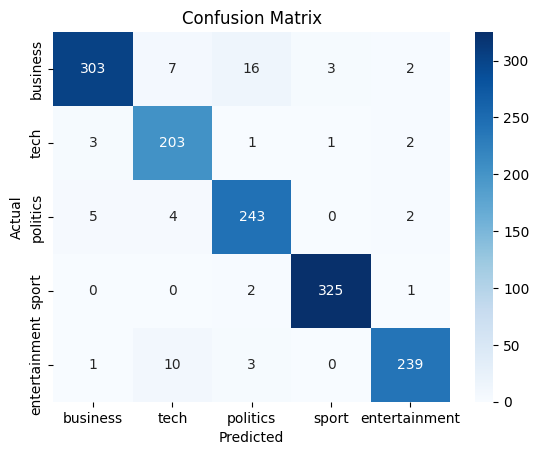

In [77]:
# Assuming these categories are present in the dataset
unique_categories = ['business', 'tech', 'politics', 'sport', 'entertainment']

# Define the function to train NMF model
def train_nmf_model(X_train, solver='mu', beta_loss='kullback-leibler', n_components=5):
    if solver == 'cd' and beta_loss != 'frobenius':
        raise ValueError("solver 'cd' only supports beta_loss='frobenius'.")
    
    nmf_model = NMF(n_components=n_components, solver=solver, beta_loss=beta_loss, random_state=42, max_iter=50)
    W_train = nmf_model.fit_transform(X_train)
    W_train_normalized = normalize(W_train, norm='l1', axis=1)
    train_predicted_labels = W_train_normalized.argmax(axis=1)
    return nmf_model, train_predicted_labels

# Define the label permutation function to maximize accuracy
def label_permute(y_true, y_pred, unique_categories, n=5):
    perms = list(itertools.permutations(range(n)))
    best_labels = []
    best_acc = 0
    for perm in perms:
        # Apply the permutation to predicted labels
        permuted_pred = [perm[label] for label in y_pred if label < n]
        # Calculate accuracy based on the permuted labels
        current_accuracy = accuracy_score(y_true, permuted_pred)
        if current_accuracy > best_acc:
            best_acc = current_accuracy
            best_labels = perm
    return best_labels, best_acc

# Solvers and beta losses to try
solvers = ['mu', 'cd']
beta_losses = ['frobenius', 'kullback-leibler']
best_accuracy = 0
best_params = {}
best_label_order = None

# Test both TF-IDF and BoW for different solver/beta_loss combinations
for method_name, X_train in [('TF-IDF', X_tfidf_train), ('BoW', X_bow_train)]:
    print(f"\nTesting {method_name}...")
    
    for solver in solvers:
        for beta_loss in beta_losses:
            # Skip invalid solver/beta_loss combinations
            if solver == 'cd' and beta_loss != 'frobenius':
                continue
            
            # Train the model
            nmf_model, train_predicted_labels = train_nmf_model(X_train, solver=solver, beta_loss=beta_loss)
            # Find the best label permutation and accuracy
            best_labels, train_accuracy = label_permute(train_cleaned_final['Category'].map(lambda x: unique_categories.index(x)), train_predicted_labels, unique_categories)
            
            # Print the accuracy for the current configuration
            print(f"Solver: {solver}, Beta Loss: {beta_loss}, Training Accuracy: {train_accuracy:.2f} ({method_name})")
            
            # Track the best accuracy and parameters across both methods
            if train_accuracy > best_accuracy:
                best_accuracy = train_accuracy
                best_params = {'method': method_name, 'solver': solver, 'beta_loss': beta_loss}
                best_label_order = best_labels

# Output the best parameters and accuracy
print(f"\nBest Parameters: {best_params}, Best Training Accuracy: {best_accuracy:.2f}")

# Apply the best parameters to train the final model
if best_params['method'] == 'TF-IDF':
    X_train_final = X_tfidf_train
else:
    X_train_final = X_bow_train

# Train the final model
nmf_model, train_predicted_labels_final = train_nmf_model(X_train_final, solver=best_params['solver'], beta_loss=best_params['beta_loss'])

# Apply the best label permutation to the predicted labels
train_predicted_labels_permuted = [best_label_order[label] for label in train_predicted_labels_final]

# Generate a confusion matrix
train_actual_labels = train_cleaned_final['Category'].map(lambda x: unique_categories.index(x))  # Actual labels as indices
conf_matrix = confusion_matrix(train_actual_labels, train_predicted_labels_permuted)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='.0f', cmap='Blues', xticklabels=unique_categories, yticklabels=unique_categories)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


***

In [78]:
# Predict the categories for the test data using TF-IDF
test_predicted_labels = nmf_model.transform(X_tfidf_test)
test_predicted_labels_normalized = normalize(test_predicted_labels, norm='l1', axis=1)
test_predicted_labels_final = test_predicted_labels_normalized.argmax(axis=1)

# Apply the best label permutation to the test predictions
test_predicted_labels_permuted = [best_label_order[label] for label in test_predicted_labels_final]

# Map the label indices back to category names
predicted_categories = [unique_categories[label] for label in test_predicted_labels_permuted]

# Create a DataFrame for the submission file
submission_df = pd.DataFrame({
    'ArticleId': test['ArticleId'],
    'Category': predicted_categories
})

# Save the submission DataFrame to a CSV file
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved as 'submission.csv'.")


Submission file saved as 'submission.csv'.


#### Results

After uploading the test data submission document to kaggle.com, I got an accuracy score of 0.96190 or 96.2% which is great but could still probable increase with more fine-tuning. 

***

<h2 id="comparison-with-supervised-learning" align="center" style="bold">Compare with supervised learning </h2>

In this section, I will compare the performance of two supervised learning models, Logistic Regression and Random Forest, with the unsupervised NMF model. By training these models on different portions of the training data (10%, 20%, and 50%), I will observe how their accuracy changes as the size of the training set increases. The goal is to evaluate how well each supervised model generalizes to the test set and to identify which method is more data-efficient. This comparison will help me understand the strengths and weaknesses of each approach and determine the best strategy for classifying the news articles.

### Logistic Regression 

In [79]:
# Define different training sizes to evaluate
train_sizes = [0.1, 0.2, 0.5]

# Initialize list to store results for Logistic Regression
results_log_reg = []

# Loop over each train size for Logistic Regression
for size in train_sizes:
    print(f"\nTraining Logistic Regression on {int(size * 100)}% of the data with Regularization:")
    
    # Split the data into training and testing sets
    X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
        X_tfidf_train, train_cleaned_final['Category'], train_size=size, random_state=42)
    
    # Train Logistic Regression model with regularization
    log_reg_model = LogisticRegression(max_iter=200, C=1.0)
    log_reg_model.fit(X_train_sample, y_train_sample)
    
    # Training and test accuracy for Logistic Regression
    train_pred_log_reg = log_reg_model.predict(X_train_sample)
    test_pred_log_reg = log_reg_model.predict(X_test_sample)
    
    train_accuracy_log_reg = accuracy_score(y_train_sample, train_pred_log_reg)
    test_accuracy_log_reg = accuracy_score(y_test_sample, test_pred_log_reg)

    print(f"Logistic Regression Training Accuracy: {train_accuracy_log_reg:.4f}")
    print(f"Logistic Regression Test Accuracy: {test_accuracy_log_reg:.4f}")
    
    # Store results for Logistic Regression
    results_log_reg.append({
        'train_size': int(size * 100),
        'train_accuracy': train_accuracy_log_reg,
        'test_accuracy': test_accuracy_log_reg
    })


Training Logistic Regression on 10% of the data with Regularization:
Logistic Regression Training Accuracy: 1.0000
Logistic Regression Test Accuracy: 0.9112

Training Logistic Regression on 20% of the data with Regularization:
Logistic Regression Training Accuracy: 0.9964
Logistic Regression Test Accuracy: 0.9010

Training Logistic Regression on 50% of the data with Regularization:
Logistic Regression Training Accuracy: 0.9985
Logistic Regression Test Accuracy: 0.9491


### Random Forrest

In [80]:
# Define different training sizes to evaluate
train_sizes = [0.1, 0.2, 0.5]

# Initialize list to store results for Random Forest
results_rf = []

# Loop over each train size for Random Forest
for size in train_sizes:
    print(f"\nTraining Random Forest on {int(size * 100)}% of the data:")
    
    # Split the data into training and testing sets
    X_train_sample, X_test_sample, y_train_sample, y_test_sample = train_test_split(
        X_tfidf_train, train_cleaned_final['Category'], train_size=size, random_state=42)
    
    # Train Random Forest model
    # Regularized Random Forest
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features='sqrt', min_samples_split=10, random_state=42)
    rf_model.fit(X_train_sample, y_train_sample)
    
    # Training and test accuracy for Random Forest
    train_pred_rf = rf_model.predict(X_train_sample)
    test_pred_rf = rf_model.predict(X_test_sample)
    
    train_accuracy_rf = accuracy_score(y_train_sample, train_pred_rf)
    test_accuracy_rf = accuracy_score(y_test_sample, test_pred_rf)
    
    print(f"Random Forest Training Accuracy: {train_accuracy_rf:.4f}")
    print(f"Random Forest Test Accuracy: {test_accuracy_rf:.4f}")
    
    # Store results for Random Forest
    results_rf.append({
        'train_size': int(size * 100),
        'train_accuracy': train_accuracy_rf,
        'test_accuracy': test_accuracy_rf
    })


Training Random Forest on 10% of the data:
Random Forest Training Accuracy: 0.9927
Random Forest Test Accuracy: 0.9072

Training Random Forest on 20% of the data:
Random Forest Training Accuracy: 0.9927
Random Forest Test Accuracy: 0.9028

Training Random Forest on 50% of the data:
Random Forest Training Accuracy: 0.9913
Random Forest Test Accuracy: 0.9142


### Comparison of Supervised Learning methods 
In this last section, I compared the performance of two supervised learning models—Logistic Regression and Random Forest—across different training sizes. Both models showed high training accuracy across all data sizes, indicating some overfitting, especially with smaller datasets.

Logistic Regression achieved slightly higher test accuracy as the training size increased, reaching 94.91% with 50% of the data. Random Forest, while consistently performing well, showed more stable test accuracy but slightly lagged behind Logistic Regression, with a test accuracy of 91.42% at 50% training size. Overall, both models generalized better as more training data was used, with Logistic Regression performing marginally better in larger datasets. My best results from submitting the running these on the test dataset and submitting to kaggle.com was 97.7% for logistic regression and 96.5% for random forrest. 

***

### Conclusion 
This project focused on classifying BBC news articles into five categories by applying various machine learning techniques. I began by performing data cleaning to remove duplicates and near-duplicate entries and used TF-IDF and Bag of Words methods for feature extraction. An unsupervised Non-Negative Matrix Factorization (NMF) model was used initially to explore latent topics in the data.

I also compared this approach with supervised learning models, observing how performance changed with different training sizes. Logistic Regression was the most effective, showing strong accuracy with larger datasets. Moving forward, future improvements could include tuning hyperparameters, using more advanced text representations like word embeddings, or implementing ensemble methods to further boost classification accuracy.

***

### Produce Deliverable

[High-Quality, Organized Jupyter Notebook Report](https://github.com/RyanOrdonez/DTSA5510_Week4_NewsClassification)

***

### Reference List

Inspiration and ideas from other Kagglers:
  - https://www.kaggle.com/code/sgjustino/bbc-news-classification/notebook
  - https://www.kaggle.com/code/mattison/unsupervised-matrix-factorization

Datasets
BBC News Dataset: "BBC News Classification Dataset," Kaggle. Available at: https://www.kaggle.com/c/learn-ai-bbc/data

